In [13]:
import torch
import itertools
import numpy as np
from scipy.linalg import det

N = 6
n = 3

# Generate combinations
I_list = list(itertools.combinations(range(1, N+1), 2))
a_list = list(itertools.combinations(range(1, N+1), n))

num_I = len(I_list)
num_a = len(a_list)
print("num_I", num_I, "num_a", num_a)
#psi = torch.zeros(num_a)
#psi[0] = 1.
psi = 2 * torch.rand(num_a) - 1.
psi /= psi.norm()

# Convert to tensors for vectorized processing
I_tensor = torch.tensor(I_list)  # (45, 2)
a_tensor = torch.tensor(a_list)  # (120, 3)

# Create empty tensor
J1 = torch.zeros((num_I, num_I, num_a))
J2 = torch.zeros((num_I, num_I, num_a))

# Levi-Civita sign function
def levi_civita_sign(big_set, sub_set):
    """
    Compute the sign of the permutation from sub_set + rest to big_set
    """
    perm = list(sub_set) + [x for x in big_set if x not in sub_set]
    idxs = [big_set.index(x) for x in perm]
    parity = np.array(idxs)
    sign = np.linalg.det(np.eye(len(parity))[parity])
    return int(round(sign))

# Main loop (vectorizable, but let's write clearly first)
for i, I in enumerate(I_list):
    for ip, Ip in enumerate(I_list):
        for a_idx, a in enumerate(a_list):
            if set(I).issubset(a):
                Jp = tuple(sorted(set(I) ^ set(a)))
                for ap_idx, ap in enumerate(a_list):
                    if set(Ip).issubset(ap):
                        Jpp = tuple(sorted(set(Ip) ^ set(ap)))
                        if Jp == Jpp:
                            s1 = levi_civita_sign(a, I)
                            s2 = levi_civita_sign(ap, Ip)
                            J1[i,ip,a_idx] += s1 * s2*psi[ap_idx]
                            J2[i,ip,ap_idx] += s1 * s2*psi[a_idx]


num_I 15 num_a 20


In [14]:
import matplotlib.pyplot as plt
def plot_spectrum(S, threshold=1e-5):
    plt.figure(figsize=(6, 4))
    x_vals = np.arange(1, 1 + len(S))
    plt.semilogy(x_vals, S, 'o-')
    plt.xlabel('Singular value index')
    plt.ylabel('Singular value (log scale)')
    plt.title('Spectrum of Jacobian Matrix')

    # Show at most 10 ticks
    tick_count = min(len(S), 10)
    tick_locs = np.linspace(1, len(S), num=tick_count, dtype=int)
    plt.xticks(tick_locs)

    # Count number of singular values greater than threshold
    count_above_threshold = np.sum(S > threshold)

    # Add text in bottom-left
    plt.text(0.05, 0.05, f'rank: {count_above_threshold}',
             transform=plt.gca().transAxes, fontsize=12, verticalalignment='bottom')

    # Add horizontal dashed line at threshold
    plt.axhline(y=threshold, color='red', linestyle='--', linewidth=1
                )

    plt.grid(True, which='both')
    plt.legend()
    plt.tight_layout()
    plt.show()
    return count_above_threshold

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


torch.Size([225, 40])


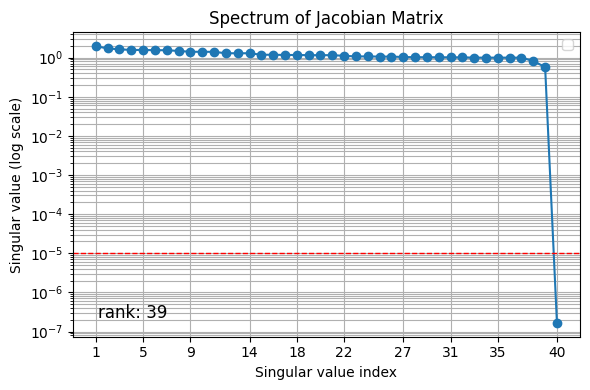

39

In [15]:
#J1 = torch.einsum('IJab,a -> IJb',k,psi)
#J1 -= torch.einsum('IJ,a -> IJa',rdm,psi)
J1 = J1.reshape(num_I**2,num_a)
#J2 = torch.einsum('IJab,b -> IJa',k,psi)
#J2 -= torch.einsum('IJ,a -> IJa',rdm,psi)
J2 = J2.reshape(num_I**2,num_a)
J = torch.cat((J1,J2),dim=1)
print(J.shape)
s = torch.linalg.svdvals(J)
plot_spectrum(np.array(s))